# Documentation

**Bayesian Inference on MERRA-2 data**

**Spencer Ressel**

2023.02.07

This notebook will be used to perform Bayesian inference on data from the MERRA-2 reanalysis product: https://gmao.gsfc.nasa.gov/reanalysis/MERRA-2/

The inference will be performed to estimate the values of several parameters specified in Ahmed (2021). 

There are several dependencies for this notebook, including many standard python packages. Special packages for Bayesian inference include the *JAX* API (https://jax.readthedocs.io/en/latest/index.html) and the *numpyro* library (https://num.pyro.ai/en/latest/index.html). 
Additionally, the notebook imports the file *mjo_mean_state_diagnostics.py*, developed by Mu-Ting Chien and modified by Spencer Ressel, which contains a series of useful functions for evaluating and analyzing geophysical data relevant to the Madden-Julian Oscillation (MJO). 

# Imports

In [103]:
import numpy as np
import xarray as xr
from scipy.integrate import trapz
from scipy import signal

import mjo_mean_state_diagnostics as mjo

from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap

import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

import arviz as az

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

# Load data
The data are MERRA-2 netCDF files of:

* Specific Humidity
* Temperature
* Zonal Wind Velocity
* Meridional Wind Velocity
* Vertical Pressure Velocity

The data is available from 1999-01-01 to 2018-12-31, on 25 pressure levels spanning 1000 hPa to 100 hPa, with zonally global 2.5°x2.5° spatial resolution in the tropics from 20°S to 20°N.

In [104]:
# Specify data location
data_folder = r"/home/disk/eos7/sressel/Research/Data/NASA/MERRA2/"

# Load specific humidity
file_name = r"merra2_data.nc"
data = xr.open_dataset(data_folder+file_name, engine="netcdf4")

specific_humidity = data['QV']
temperature = data['T']
zonal_velocity = data['U']
meridional_velocity = data['V']
vertical_velocity = data['OMEGA']

longitude = data['lon']
latitude = data['lat']
pressure_levels = data['lev']
time = data['time']

variables_dict = {
    'specific humidity':specific_humidity,
    'temperature':temperature,
    'zonal velocity':zonal_velocity,
    'meridional velocity':meridional_velocity,
    'vertical velocity':vertical_velocity
}

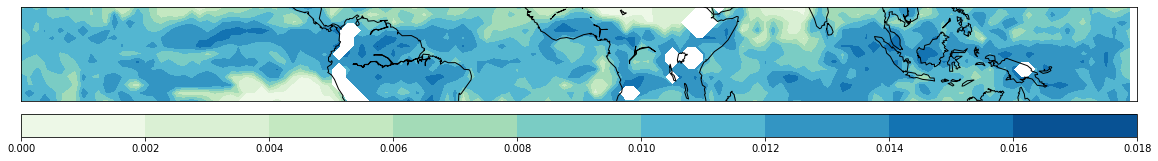

In [105]:
[fig, ax] = plt.subplots(figsize=(20, 10))

m = Basemap(projection='merc',lon_0=0, lat_0=0, llcrnrlat=-15,urcrnrlat=15,llcrnrlon=-180,urcrnrlon=180)
m.drawcoastlines()
# m.fillcontinents(color='white')

[longitude_mesh, latitude_mesh] = np.meshgrid(longitude, latitude)

cf = m.contourf(
    longitude_mesh, 
    latitude_mesh, 
    specific_humidity[100,6], 
    cmap='GnBu', 
    latlon=True
)
fig.colorbar(cf, ax=ax, aspect=50, pad=0.025, orientation='horizontal')

plt.show()

# Data processing

## Subset the data
We're only looking at data at the location (80°E, 0)

In [106]:
# Create a dictionary to hold the subset arrays
variables_subset = {}

for variable in variables_dict:
    variables_subset[variable] = variables_dict[variable].sel(lon=slice(60, 130), lev=slice(850,100))  
    
pressure_levels = pressure_levels.sel(lev=slice(850,100))
longitude = longitude.sel(lon=slice(60, 130))

## Detrend data in time

In [107]:
variables_detrended = {}

for variable in variables_dict:
    variables_detrended[variable] = signal.detrend(variables_subset[variable], axis=0, type='linear')

## Remove the annual cycle and first three harmonics

In [108]:
variables_deannualized = {}
variables_annual_cycle = {}

for variable in variables_dict:
    [           
        variables_deannualized[variable],
        variables_annual_cycle[variable] 
    ] = mjo.remove_annual_cycle_matrix(
        variables_detrended[variable], 
        time=time, 
        lev=pressure_levels, 
        lat=latitude,
        lon=longitude
    )    

## Filter the data for MJO signals

In [109]:
variables_filtered = {}
for variable in variables_dict:
    variables_filtered[variable] = mjo.lanczos_bandpass_filter(
        variables_deannualized[variable],
        lowcut=(1 / 100),
        highcut=(1 / 20),
        fs=1,
        filter_axis=0,
    )

## Select boreal winter points
Specifically November-March

In [110]:
YYYYMMDD_time = mjo.datetime64_to_yyyymmdd(time.values)
[year, month, day] = mjo.yyyymmdd_y_m_d(YYYYMMDD_time)
boreal_winter_indices = np.squeeze(np.where((month >= 11) | (month <= 3)))

In [111]:
variables_boreal_winter = {}
variables_boreal_winter_mean = {}

for variable in variables_dict:
    variables_boreal_winter[variable] = variables_filtered[variable][boreal_winter_indices]
    variables_boreal_winter_mean[variable] = np.mean(variables_boreal_winter[variable], axis=0)


In [112]:
variables_time_mean = {}

for variable in variables_dict:
    variables_time_mean[variable] = np.mean(variables_filtered[variable], axis=0)


## Compute vertical EOF structures
First flatten the data spatially, so it has shape (len(pressure_levels), len(latitude) x len(longitude))
Then the pressure levels will be the structure dimension, and latitude and longitude will be the sampling dimension. The first EOF will be the baroclinic mode of each of the variables over this region for the MJO

In [113]:
variables_flattened = {}

for variable in variables_dict:
    variables_flattened[variable] = np.reshape(
        variables_time_mean[variable], 
        (
            len(pressure_levels),
            len(latitude)*len(longitude)
        )
    )

In [114]:
variables_meridionally_averaged = {}

for variable in variables_dict:
    variables_meridionally_averaged[variable] = np.average(
        variables_time_mean[variable], 
        weights=np.abs(np.sin(np.pi*latitude/180)),
        axis=1
    )

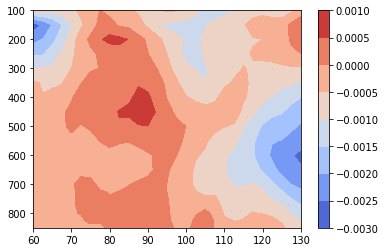

In [115]:
variables_meridionally_averaged['zonal velocity'].shape
plt.contourf(longitude, 
             pressure_levels, 
             variables_meridionally_averaged['zonal velocity'],
             cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

In [116]:
variables_EOF = {}
variables_PC = {}

for variable in variables_dict:
    [
        variables_EOF[variable],
        variables_PC[variable], 
        eigval, 
        eigval_explained_var, 
        eigval_err, 
        dof, 
        phi_0, 
        phi_L
    ] = mjo.eof(variables_flattened[variable])

## Project data onto first EOF

In [117]:
variables_projected_vertically = {}

for variable in variables_dict:
    variables_projected_vertically[variable] = np.einsum(
        'j,ijkl->ikl', 
        variables_EOF[variable][0], 
        variables_filtered[variable]
    ) 

In [118]:
# [fig, ax] = plt.subplots(figsize=(20, 10))

# m = Basemap(projection='merc',lon_0=0, lat_0=0, llcrnrlat=-15,urcrnrlat=15,llcrnrlon=60,urcrnrlon=130)
# m.drawcoastlines()
# # m.fillcontinents(color='white')

# [longitude_mesh, latitude_mesh] = np.meshgrid(longitude, latitude)

# cf = m.contourf(
#     longitude_mesh, 
#     latitude_mesh, 
#     variables_projected_vertically['zonal velocity'][1000], 
#     cmap='coolwarm', 
#     latlon=True,
#     levels=21
# )
# fig.colorbar(cf, ax=ax, aspect=50, pad=0.025, orientation='horizontal')

# plt.show()

In [119]:
single_location_data = {}

for variable in variables_dict:
    single_location_data[variable] = variables_projected_vertically[variable][:,8,10]

In [120]:
single_location_data['specific humidity']
moisture_tendency = np.gradient(single_location_data['specific humidity'], 1)

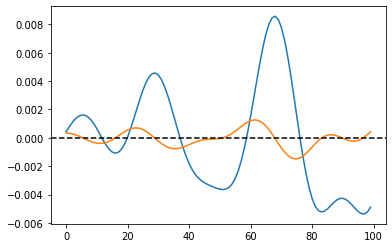

In [121]:
plt.figure()
plt.plot(single_location_data['specific humidity'][:100])
plt.plot(moisture_tendency[:100])
plt.axhline(y=0, color='k', ls='--')

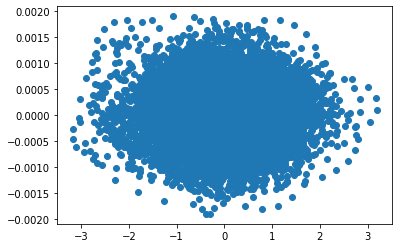

In [122]:
plt.scatter(single_location_data['temperature'], moisture_tendency)

## Project data onto meridional modes

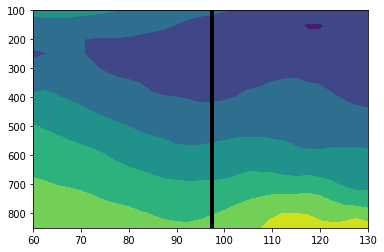

In [123]:
plt.figure()
plt.contourf(longitude, pressure_levels, variables_boreal_winter_mean['zonal velocity'][:,15,:])
plt.axvline(x=longitude[15], lw=4, color='k', zorder=10)
plt.gca().invert_yaxis()

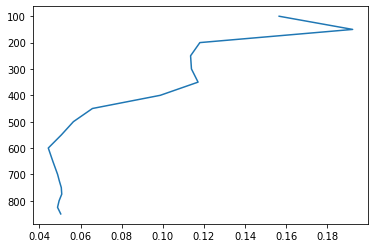

In [124]:
plt.figure()
plt.plot(variables_boreal_winter_mean['zonal velocity'][:,8,15], pressure_levels)
plt.gca().invert_yaxis()

In [125]:
longitude[0]

<xarray.DataArray 'lon' ()>
array(60.)
Coordinates:
    lon      float64 60.0
Attributes:
    standard_name:  longitude
    long_name:      longitude
    units:          degrees_east
    axis:           X

In [127]:
# [fig, ax] = plt.subplots(figsize=(20, 10))

# m = Basemap(projection='merc',lon_0=0, lat_0=0, llcrnrlat=-15,urcrnrlat=15,llcrnrlon=60,urcrnrlon=130)
# m.drawcoastlines()
# # m.fillcontinents(color='white')

# [longitude_mesh, latitude_mesh] = np.meshgrid(longitude, latitude)

# cf = m.contourf(
#     longitude_mesh, 
#     latitude_mesh, 
#     variables_projected_vertically['meridional velocity'], 
#     cmap='coolwarm', 
#     latlon=True,
#     levels=21
# )
# fig.colorbar(cf, ax=ax, aspect=50, pad=0.025, orientation='horizontal')

# plt.show()

In [128]:
def model(u, v, y, omega, T, q, moisture_tendency):
    sigma_x = numpyro.sample('sigma_x', dist.Uniform(-10,10))
    sigma_y = numpyro.sample('sigma_y', dist.Uniform(-10,10))
    M_q = numpyro.sample('M_q', dist.LogNormal(0, 1.0))
    epsilon_q = numpyro.sample('epsilon_q', dist.LogNormal(0, 1.0))
    epsilon_t = numpyro.sample('epsilon_t', dist.LogNormal(0, 1.0))
    dqdt = numpyro.deterministic('dqdt', sigma_x*u - sigma_y*y*v - M_q*omega - epsilon_q*q + epsilon_t*T)
    
    numpyro.sample('obs', dist.Normal(dqdt), obs=moisture_tendency)

In [129]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)

# Run NUTS.
kernel = NUTS(model, adapt_step_size=True)
num_samples = 4000
mcmc = MCMC(kernel, num_chains=1, num_warmup=1000, num_samples=num_samples)
mcmc.run(
    rng_key, 
    single_location_data['zonal velocity'],
    single_location_data['meridional velocity'],
    0,
    single_location_data['vertical velocity'],
    single_location_data['temperature'],
    single_location_data['specific humidity'],
    moisture_tendency
)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

sample: 100%|█| 5000/5000 [25:22<00:00,  3.28it/s, 1023 steps of size 3.87e-08.



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
        M_q      0.51      0.00      0.51      0.51      0.51      0.50      1.00
  epsilon_q      2.45      0.00      2.45      2.45      2.45      0.50      1.00
  epsilon_t      5.48      0.00      5.48      5.48      5.48       nan       nan
    sigma_x      6.63      0.00      6.63      6.63      6.63      0.50      1.00
    sigma_y      7.47      0.00      7.47      7.47      7.47       nan       nan

Number of divergences: 0


/home/disk/p/sressel/.local/lib/python3.6/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


ValueError: cannot convert float NaN to integer

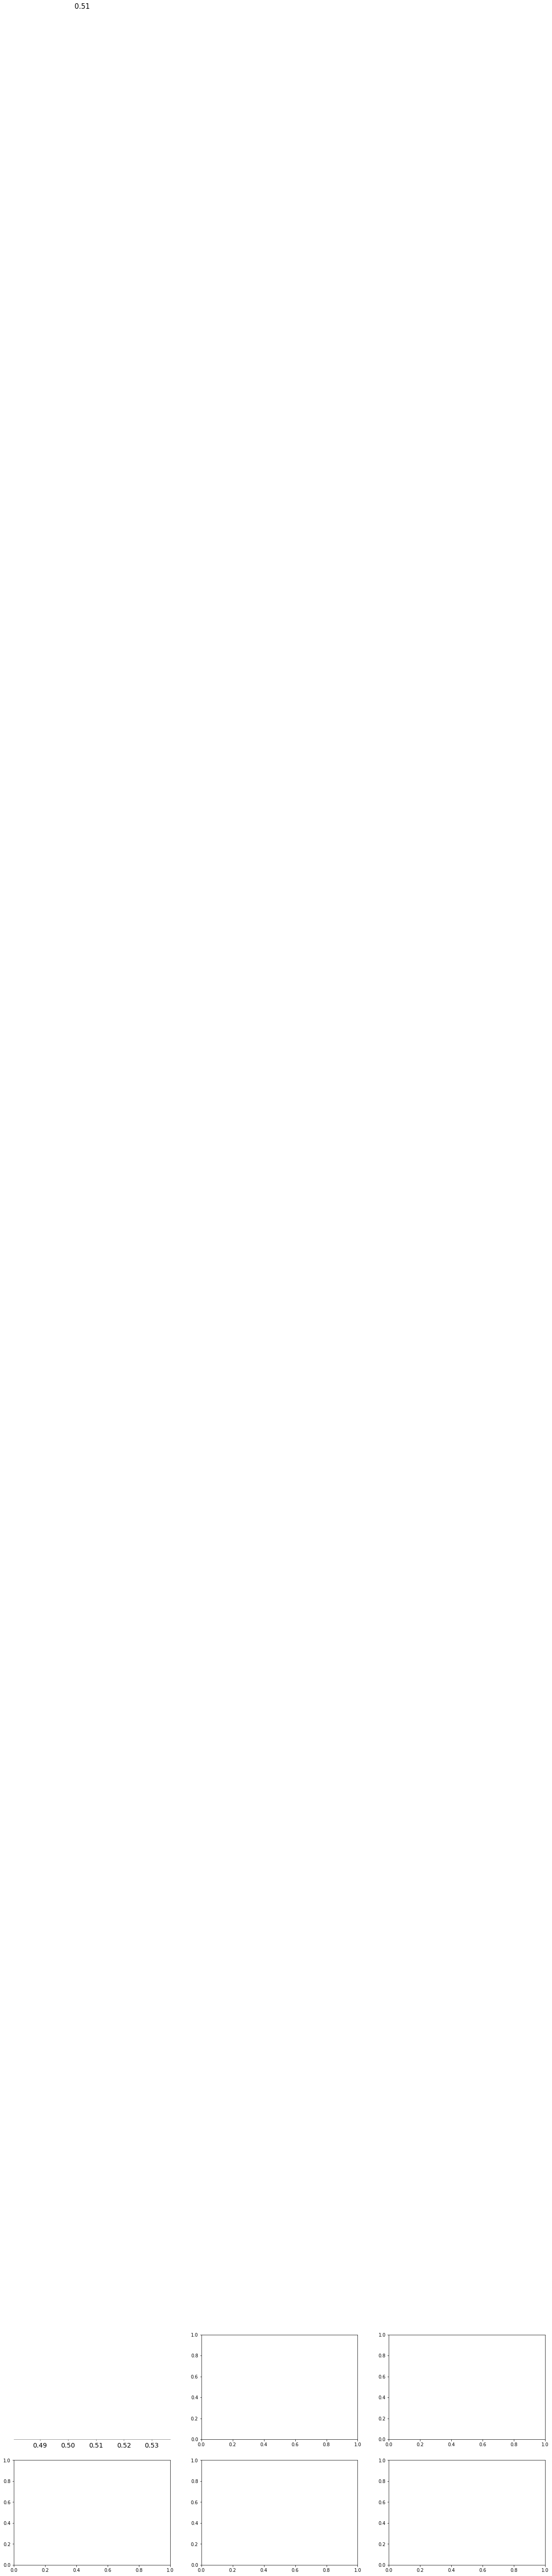

In [130]:
az.plot_posterior(samples_1)

In [ ]:
np.where(np.isnan(samples_1['sigma_y']))